In [14]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
cus_soc_pref_file = DATA_PATH + "CUS_social_pref_projection.pkl"
proj_file = PROJECT_PATH + "CUS_social_pref_projection.csv"
mean_file = PROJECT_PATH + "CUS_social_pref_mean_scores.csv"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


FEATURE_LIST = ['X_psd','X_coh','X_gc']
FEATURE_WEIGHT = [10,1,1]

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

def get_3_net_aucs(s,y,y_group=None):
    
    auc_mean_list = []
    auc_stderr_list =[]
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        mean = np.mean([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"])
        stderr = np.std([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"]) / np.sqrt(len(auc_dict.keys()))
        
        auc_mean_list.append(mean)
        auc_stderr_list.append(stderr)
        
    return auc_mean_list, auc_stderr_list

def get_3_net_auc_dict(s,y,y_group=None):
    auc_dict_list = []
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        auc_dict_list.append(auc_dict)
        
    return auc_dict_list

In [2]:
dataDict = pickle.load(open(cus_soc_pref_file,"rb"))

X = np.hstack([weight*dataDict[feature] for weight,feature in zip(FEATURE_WEIGHT,FEATURE_LIST)])
y_time = dataDict['y_time']
y_mouse = np.array(dataDict['y_mouse'])
y_social = dataDict['y_social'].squeeze()
y_object = dataDict['y_object'].squeeze()
y_nan = dataDict['y_nan']
y_stressed = np.array([mouse[-3]=='S' for mouse in y_mouse])

In [3]:
not_nan_mask = (1-y_nan).squeeze()
soc_or_obj_mask = np.logical_or(y_social,y_object)
pred_mask = np.logical_and(soc_or_obj_mask,not_nan_mask)

soc_v_object = model.score(X[pred_mask==1,:],
                           y_social[pred_mask==1].reshape(-1,1),
                           y_mouse[pred_mask==1],
                           return_dict=True)
soc_v_object_list = [soc_v_object[key] for key in soc_v_object.keys()]
mean_soc_v_object = np.mean(soc_v_object_list)
sterr_soc_v_object = np.std(soc_v_object_list) / np.sqrt(len(soc_v_object_list))

stressed_v_control = model.score(X,y_stressed)

print("Social vs Object AUC: {:.3f} +/- {:.3f} (n={})".format(mean_soc_v_object,sterr_soc_v_object,len(soc_v_object_list)))
print("Stressed vs Control {:.3f}".format(stressed_v_control))

Social vs Object AUC: 0.502 +/- 0.014 (n=12)
Stressed vs Control 0.688


In [7]:
s = model.project(X)
soc_v_object_3_net = get_3_net_auc_dict(s[pred_mask==1],y_social[pred_mask==1],y_mouse[pred_mask==1])
stressed_v_control_3_net = get_3_net_auc_dict(s,y_stressed)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())
agg_score = s[:,:3] @ coeffs

results_dict = {
    "agg scores":agg_score,
    "net 1 scores":s[:,0],
    "net 2 scores":s[:,1],
    "net 3 scores":s[:,2],
    
    "mouse":y_mouse,
    "social":y_social,
    "object":y_object,
    "time":y_time,
    "stressed":y_stressed,
    
    "soc vs obj auc": [soc_v_object[mouse][0] for mouse in y_mouse],
    "net 1 soc vs obj auc": [soc_v_object_3_net[0][mouse][0] for mouse in y_mouse],
    "net 2 soc vs obj auc": [soc_v_object_3_net[1][mouse][0] for mouse in y_mouse],
    "net 3 soc vs obj auc": [soc_v_object_3_net[2][mouse][0] for mouse in y_mouse],

    "stressed vs control auc": [stressed_v_control for mouse in y_mouse],
    "net 1 stressed vs control auc": [stressed_v_control_3_net[0][1][0] for mouse in y_mouse],
    "net 2 stressed vs control auc": [stressed_v_control_3_net[1][1][0] for mouse in y_mouse],
    "net 3 stressed vs control auc": [stressed_v_control_3_net[2][1][0] for mouse in y_mouse],

}

df_proj = pd.DataFrame.from_dict(results_dict)
#df_proj.to_csv(proj_file)
df_proj.head()

,agg scores,net 1 scores,net 2 scores,net 3 scores,mouse,social,object,time,stressed,soc vs obj auc,net 1 soc vs obj auc,net 2 soc vs obj auc,net 3 soc vs obj auc,stressed vs control auc,net 1 stressed vs control auc,net 2 stressed vs control auc,net 3 stressed vs control auc
0,3.831825,0.042224,0.201434,0.082413,MouseC5C12,1.0,-0.0,1,False,0.561219,0.530827,0.563951,0.513491,0.688453,0.685661,0.669101,0.565034
1,3.909334,0.047726,0.203433,0.068971,MouseC5C12,1.0,-0.0,2,False,0.561219,0.530827,0.563951,0.513491,0.688453,0.685661,0.669101,0.565034
2,3.756082,0.046735,0.196839,0.022529,MouseC5C12,1.0,-0.0,3,False,0.561219,0.530827,0.563951,0.513491,0.688453,0.685661,0.669101,0.565034
3,2.049797,0.032056,0.101359,0.063311,MouseC5C12,1.0,-0.0,4,False,0.561219,0.530827,0.563951,0.513491,0.688453,0.685661,0.669101,0.565034
4,2.215187,0.036353,0.109346,0.049669,MouseC5C12,1.0,-0.0,5,False,0.561219,0.530827,0.563951,0.513491,0.688453,0.685661,0.669101,0.565034


In [5]:
mouse_list = []
stressed_list = []
avg_score_list = []
avg_social_score_list = []
avg_object_score_list = []

for mouse in np.unique(y_mouse):
    mouse_mask=y_mouse==mouse
    social_mouse_mask = np.logical_and(mouse_mask,y_social)
    object_mouse_mask = np.logical_and(mouse_mask,y_object)
    avg_score = np.mean(s[mouse_mask==1,:3],axis=0)
    avg_social_score = np.mean(s[social_mouse_mask==1,:3],axis=0)
    avg_object_score = np.mean(s[object_mouse_mask==1,:3],axis=0)
    
    mouse_list.append(mouse)
    stressed_list.append(mouse[-3]=="S")
    avg_score_list.append(avg_score)
    avg_social_score_list.append(avg_social_score)
    avg_object_score_list.append(avg_object_score)
    

avg_score_list = np.array(avg_score_list)
avg_social_score_list = np.array(avg_social_score_list)
avg_object_score_list = np.array(avg_object_score_list)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())

mag_scores = avg_score_list*coeffs
mag_social_scores = avg_social_score_list*coeffs
mag_object_scores= avg_object_score_list*coeffs

scoresImpact = mag_scores / np.sum(mag_scores,axis=1).reshape(-1,1)
social_scoresImpact = mag_social_scores / np.sum(mag_social_scores,axis=1).reshape(-1,1)
object_scoresImpact = mag_object_scores / np.sum(mag_object_scores,axis=1).reshape(-1,1)

scores_dict = {
    "mouse":mouse_list,
    "Stressed":stressed_list,
    
    "composite avgScore":np.sum(mag_scores,axis=1),
    "composite avgSocScore":np.sum(mag_social_scores,axis=1),
    "composite avgObjScore":np.sum(mag_object_scores,axis=1),
    
    "net 1 avgScore":avg_score_list[:,0],
    "net 1 avgSocScore":avg_social_score_list[:,0],
    "net 1 avgObjScore":avg_object_score_list[:,0],
    "net 2 avgScore":avg_score_list[:,1],
    "net 2 avgSocScore":avg_social_score_list[:,1],
    "net 2 avgObjScore":avg_object_score_list[:,1],
    "net 3 avgScore":avg_score_list[:,2],
    "net 3 avgSocScore":avg_social_score_list[:,2],
    "net 3 avgObjScore":avg_object_score_list[:,2],
    
    "net 1 avgImpact":scoresImpact[:,0],
    "net 1 avgSocImpact":social_scoresImpact[:,0],
    "net 1 avgObjImpact":object_scoresImpact[:,0],
    "net 2 avgImpact":scoresImpact[:,1],
    "net 2 avgSocImpact":social_scoresImpact[:,1],
    "net 2 avgObjImpact":object_scoresImpact[:,1],
    "net 3 avgImpact":scoresImpact[:,2],
    "net 3 avgSocImpact":social_scoresImpact[:,2],
    "net 3 avgObjImpact":object_scoresImpact[:,2],
}

df_mean = pd.DataFrame.from_dict(scores_dict)
#df_mean.to_csv(mean_file)
df_mean.head()

,mouse,Stressed,composite avgScore,composite avgSocScore,composite avgObjScore,net 1 avgScore,net 1 avgSocScore,net 1 avgObjScore,net 2 avgScore,net 2 avgSocScore,...,net 3 avgObjScore,net 1 avgImpact,net 1 avgSocImpact,net 1 avgObjImpact,net 2 avgImpact,net 2 avgSocImpact,net 2 avgObjImpact,net 3 avgImpact,net 3 avgSocImpact,net 3 avgObjImpact
0,MouseC5C12,False,3.214894,3.301914,3.147476,0.053376,0.056226,0.054264,0.159579,0.163176,...,0.041338,0.162616,0.166784,0.168864,0.827638,0.823992,0.821635,0.009746,0.009224,0.009502
1,MouseC5C13,False,3.347562,3.340787,3.395895,0.113702,0.112784,0.113370,0.132772,0.132883,...,0.028605,0.332679,0.330664,0.326986,0.661315,0.663213,0.666920,0.006006,0.006123,0.006094
2,MouseC5C20,False,1.861171,2.154793,2.184021,0.053505,0.059218,0.058698,0.078087,0.092309,...,0.051497,0.281577,0.269175,0.263239,0.699557,0.714285,0.719703,0.018866,0.016539,0.017058
3,MouseC5C22,False,2.881192,2.857449,2.976892,0.072549,0.071801,0.076167,0.128476,0.127525,...,0.039760,0.246631,0.246115,0.250606,0.743500,0.744129,0.739731,0.009869,0.009757,0.009663
4,MouseC5C23,False,1.418211,1.476205,1.336657,0.049394,0.049622,0.047675,0.054398,0.057697,...,0.038268,0.341133,0.329243,0.349345,0.639552,0.651684,0.629943,0.019315,0.019073,0.020712


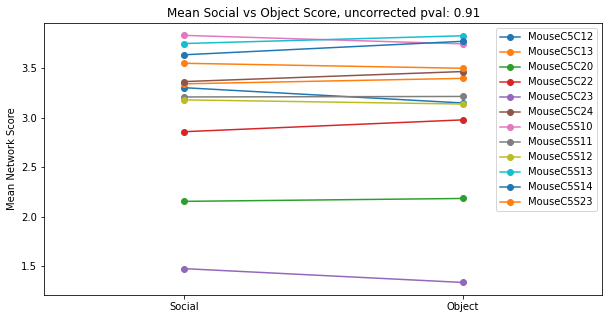

In [15]:
from scipy.stats import wilcoxon

results = wilcoxon(df_mean["composite avgSocScore"],df_mean["composite avgObjScore"])

temp = np.hstack([df_mean["composite avgSocScore"].to_numpy().reshape(-1,1),df_mean["composite avgObjScore"].to_numpy().reshape(-1,1)])

plt.figure(figsize=(10,5))
for i, mouse in enumerate(df_mean["mouse"]):
    plt.plot(temp[i,:],"o-",label=mouse)
    
plt.xticks([0,1],["Social","Object"])
plt.ylabel("Mean Network Score")
plt.xlim([-.5,1.5])
plt.legend()
plt.title("Mean Social vs Object Score, uncorrected pval: {:.2f}".format(results.pvalue))
plt.savefig(FIGURE_PATH + "CUS SocialPref Social vs Obj Wilcox.svg")
plt.show()

In [11]:
temp.shape

(12, 2)